In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from obtain_thresholds import read_img_data_from_disk, k_fold_cross_validation
from Localization import plate_detection

In [ ]:
X = read_img_data_from_disk('./dataset/ColourVariations')

randomise = np.arange(X.shape[0])
X = X[randomise]

In [ ]:
X.shape

In [ ]:
k_fold_cross_validation(X, 5, 3)

In [ ]:
df = pd.read_csv('./dataset/bounding_boxes.csv')

In [ ]:
category_1 = df.iloc[:32]
path = './dataset/Frames/Category_I/'
avg_intersection_over_union_i = 0

for i in range(32):
    row = category_1.iloc[i]
    bounding_box = BoundingBox(row['Left'], row['Top'], row['Right'], row['Bottom'])

    frame = cv2.imread(path + row['Image'])
    plates = plate_detection(frame)

    if len(plates[1]):
        avg_intersection_over_union_i += (bounding_box.intersection_over_union(plates[1][0]))
print(f'Detected correctly Category I: {avg_intersection_over_union_i / 32}')

In [ ]:
category_2 = df.iloc[32:60]
path = './dataset/Frames/Category_II/'
avg_intersection_over_union_ii = 0

for i in range(28):
    row = category_2.iloc[i]
    bounding_box = BoundingBox(row['Left'], row['Top'], row['Right'], row['Bottom'])

    frame = cv2.imread(path + row['Image'])
    plates = plate_detection(frame)

    if len(plates[1]):
        avg_intersection_over_union_ii += (bounding_box.intersection_over_union(plates[1][0]))
print(f'Detected correctly Category II: {avg_intersection_over_union_ii / 28}')

In [ ]:
category_3 = df.iloc[60:]
path = './dataset/Frames/Category_III/'
avg_intersection_over_union_iii = 0

for i in range(0, 10, 2):
    row_1 = category_3.iloc[i]
    row_2 = category_3.iloc[i+1]

    bounding_box_1 = BoundingBox(row_1['Left'], row_1['Top'], row_1['Right'], row_1['Bottom'])
    bounding_box_2 = BoundingBox(row_2['Left'], row_2['Top'], row_2['Right'], row_2['Bottom'])

    frame = cv2.imread(path + row_1['Image'])
    plates = plate_detection(frame)

    if len(plates[1]) == 1:
        b1 = bounding_box_1.intersection_over_union(plates[1][0])
        b2 = bounding_box_2.intersection_over_union(plates[1][0])

        if b1 < b2:
            b1 = b2

        avg_intersection_over_union_iii += b1
    elif len(plates[1]) == 2:
        b1 = bounding_box_1.intersection_over_union(plates[1][0])
        b2 = bounding_box_2.intersection_over_union(plates[1][0])
        b3 = bounding_box_1.intersection_over_union(plates[1][1])
        b4 = bounding_box_2.intersection_over_union(plates[1][1])

        op1 = b1
        op2 = b2

        if b3 > op1:
            op1 = b3

        if b4 > op2:
            op2 = b4

        avg_intersection_over_union_iii += op2 + op1
print(f'Detected correctly Category III: {avg_intersection_over_union_iii / 10}')

In [2]:
from test_pipeline import localize_and_rotate
from pre_processing_data import read_image
from Segment import remove_black_rows, dilate_or_erode, clear_top_bottom
from pre_processing_data import read_reference_characters
from character_recognition import recognise_character
import Helpers

In [3]:
frame = cv2.imread('./dataset/Frames/Category_I/plate12.jpg')
plates = localize_and_rotate(frame)
plate = cv2.cvtColor(plates[0], cv2.COLOR_BGR2GRAY)
plate = Helpers.isodata_thresholding(plate)
plate = clear_top_bottom(plate)

In [4]:
plate = np.array(plate, np.uint8)

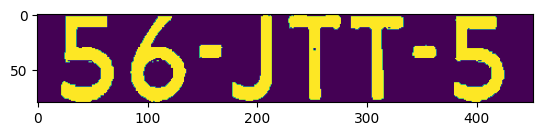

In [5]:
plt.imshow(plate)

In [6]:
contours, _ = cv2.findContours(plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [7]:
mean_area = 0
plate_area = plate.shape[0] * plate.shape[1]
for contour in contours:
    contour_area = cv2.contourArea(contour)
    if contour_area < plate_area * 0.5:
        mean_area += contour_area

mean_area /= len(contours)    
threshold_area = mean_area * 0.5

bounding_boxes = []

for contour in contours:
    contour_area = cv2.contourArea(contour)
    if contour_area >= plate_area * 0.7:
        continue

    if contour_area > threshold_area:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((plate[y:y+h, x:x+w], x))

In [8]:
bounding_boxes.sort(key=lambda x: x[1])

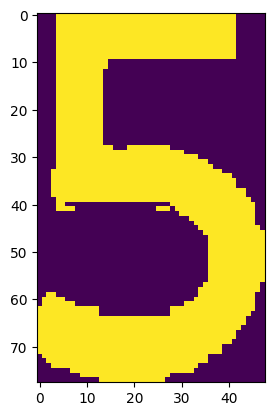

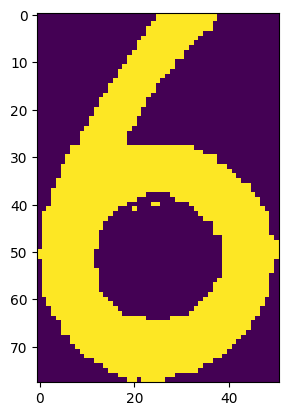

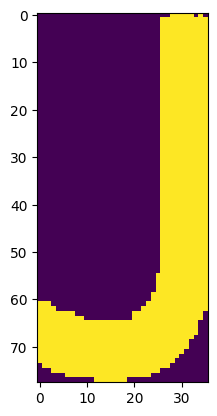

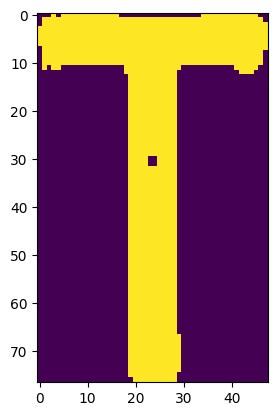

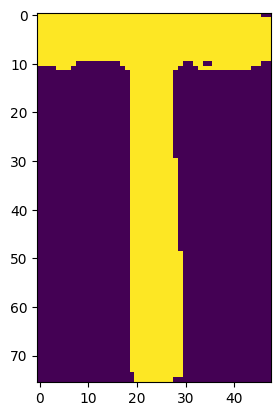

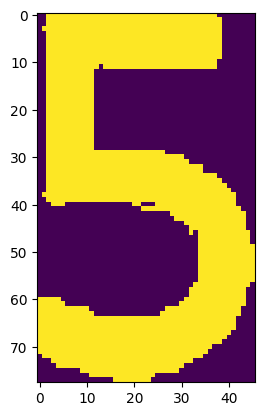

In [9]:
for bounding_box in bounding_boxes:
    plt.imshow(bounding_box[0])
    plt.show()

In [10]:
reference_characters = read_reference_characters('./dataset/Lab07-Dataset')

In [16]:
recognise_character(reference_characters, bounding_boxes[0][0])

(0.07665598290598291, '5')